In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from itertools import product
from sklearn.linear_model import LinearRegression, MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

from ylearn.exp_dataset.exp_data import single_continuous_treatment, single_binary_treatment, multi_continuous_treatment
from ylearn.estimator_model.double_ml import DML4CATE
from ylearn.estimator_model.utils import nd_kron

## Single continuous treatment.
Valid estimation models include
- DoubleML
- DeepIV
- CausalTree

### The dataset is generated by the following process [1]
Below we use the einstein notation to alleviate the headaches of specifiying dimensions of tensors.
\begin{align*}
    x & = \beta_i w^i \\
    y & = x \theta(v^i) + \gamma_j w^j + \epsilon \\
    w & \sim \text{Normal}(0, I_{n_w})\\
    v & \sim \text{Uniform}(0, 1)^{n_v}
\end{align*}

In [3]:
train, val, treatment_effect = single_continuous_treatment()

In [4]:
train

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_24,w_25,w_26,w_27,w_28,w_29,c_0,treatment,outcome,TE
1212,-1.010090,-1.793770,-0.704964,0.083557,0.481427,-0.048769,-0.194278,-0.817631,0.267509,0.388186,...,0.705857,-1.235907,-1.240211,0.307156,-0.250887,0.955369,0.155103,-0.049943,-0.391496,1.363705
1690,0.458838,0.284358,-0.456428,1.166463,-1.124323,-0.093801,3.306066,1.980896,0.628333,-0.282192,...,-2.091498,0.994543,2.341314,0.946668,0.601337,-0.028910,0.335181,-0.495657,-0.884389,1.954943
1198,-0.894299,0.720393,1.682601,0.215710,0.732282,-1.210671,0.305657,-0.427936,3.042174,-0.673378,...,0.527429,1.084672,0.017845,-1.970667,0.183399,0.292241,0.547452,1.082807,3.535996,2.988898
401,-0.298571,-1.671269,0.260021,-1.836556,1.249896,-2.137694,0.234445,-1.012757,-0.203846,-0.045091,...,-0.147662,0.010062,-0.701577,-0.903222,-0.303378,-1.196278,0.477712,-0.726763,-5.814209,2.599774
512,-0.008337,0.312129,2.535573,-1.778272,2.412057,-2.550452,0.696291,1.054566,1.074932,-0.494271,...,1.084067,-1.606550,0.782404,0.928994,-2.466212,-1.042824,0.076972,3.144719,5.347627,1.166426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,0.473488,-0.246827,-0.829371,0.167178,2.051812,-1.098893,-2.022564,1.115111,-0.843840,0.027017,...,0.659410,-0.066118,0.836309,-0.187636,-1.201602,-0.812195,0.887783,1.707117,9.797455,5.903625
929,0.062928,0.663101,-0.003895,0.283313,0.150168,0.676016,-0.800642,-2.142750,1.956881,-0.023682,...,0.492842,-0.446452,-1.392282,0.161448,-0.281472,2.292087,0.540622,0.008218,1.633430,2.948346
652,-0.474054,-0.208888,0.843013,1.233498,0.275309,2.065287,0.029058,0.007994,1.498871,0.045821,...,2.251417,-0.007995,-0.729207,0.872539,-1.748384,-0.784325,0.720702,-1.758245,-10.299303,4.226625
553,0.144784,-0.631134,-0.768283,0.646175,-2.800647,0.303113,1.030039,0.206670,0.752679,0.937146,...,-1.607408,1.784038,0.048513,0.593881,1.885963,0.295527,0.217212,-0.660572,0.237139,1.544072


In [5]:
adjustment = train.columns[:-4]
covariate = 'c_0'
outcome = 'outcome'
treatment = 'treatment'

In [6]:
dml = DML4CATE(
    x_model=RandomForestRegressor(),
    y_model=RandomForestRegressor(),
    cf_fold=3,
)
dml.fit(
    train,
    outcome,
    treatment,
    adjustment,
    covariate, 
)

DML4CATE(x_model=RandomForestRegressor(), y_model=RandomForestRegressor(), yx_model=LinearRegression(), cf_fold=3)

In [7]:
dml_poly={}
for dg in [3,5]:
    dml_t = DML4CATE(
        x_model=RandomForestRegressor(),
        y_model=RandomForestRegressor(),
        cf_fold=3,    
        covariate_transformer = PolynomialFeatures(degree=dg,include_bias=False)
    )
    dml_t.fit(
        train,
        outcome,
        treatment,
        adjustment,
        covariate, 
    )
    dml_poly[dg] = dml_t

In [8]:
def exp_te(x): return np.exp(2*x)
dat = np.array(list(product(np.arange(0, 1, 0.01), repeat=1))).ravel()
data_test = pd.DataFrame({'c_0': dat})
true_te = np.array([exp_te(xi) for xi in data_test[covariate]])
ested_te = dml.estimate(data_test).ravel()


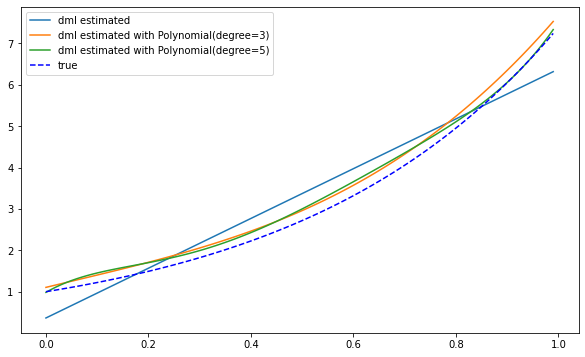

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(dat, ested_te, label='dml estimated')
for dg, est in dml_poly.items():
    ested_te_dg = est.estimate(data_test).ravel()
    plt.plot(dat, ested_te_dg, label=f'dml estimated with Polynomial(degree={dg})')
plt.plot(dat, true_te, 'b--', label='true')
plt.legend()
plt.show()

## Single binary treatment.
Valid estimation models include
- DoubleML
- DeepIV
- CausalTree
- Metalearners
- DoublyRobust

### The dataset is generated by the following process
Below we use the einstein notation to alleviate the headaches of specifiying dimensions of tensors.
\begin{align*}
    x & \sim \text{Bernoulli}(f(w)), \quad f(w) = \sigma(w_i \beta^i + \eta), \quad \eta\sim \text{Uniform}(-1, 1) \\
    y & = x \theta(v^i) + \gamma_j w^j + \epsilon, \quad \epsilon \sim \text{Uniform}(-1, 1)\\
    w & \sim \text{Normal}(0, I_{n_w})\\
    v & \sim \text{Uniform}(0, 1)^{n_v}
\end{align*}

In [10]:
train1, val1, treatment_effect1 = single_binary_treatment()
def exp_te(x): return np.exp(2*x[0])
n = 1000
n_x = 4
X_test1 = np.random.uniform(0, 1, size=(n, n_x))
X_test1[:, 0] = np.linspace(0, 1, n)
data_test_dict = {
    'c_0': X_test1[:, 0],
    'c_1': X_test1[:, 1],
    'c_2': X_test1[:, 2],
    'c_3': X_test1[:, 3],
}
data_test1 = pd.DataFrame(data_test_dict)
true_te = np.array([exp_te(x_i) for x_i in X_test1])

In [11]:
adjustment1 = train1.columns[:-7]
covariate1 = train1.columns[-7:-3]
# t_effect1 = train1['t_effect']
treatment = 'treatment'
outcome = 'outcome'

In [12]:
dml1 = DML4CATE(
    x_model=RandomForestClassifier(),
    y_model=RandomForestRegressor(),
    cf_fold=1,
    is_discrete_treatment=True,
)
dml1.fit(
    data=train1,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment1,
    covariate=covariate1,
)
predicted = dml1.estimate(data_test1)

In [13]:
data_test1

,c_0,c_1,c_2,c_3
0,0.000000,0.818433,0.631912,0.956283
1,0.001001,0.167187,0.670090,0.500090
2,0.002002,0.993322,0.075953,0.045508
3,0.003003,0.973807,0.526946,0.705518
4,0.004004,0.064636,0.876281,0.067465
...,...,...,...,...
995,0.995996,0.941305,0.259215,0.236504
996,0.996997,0.909833,0.555308,0.247834
997,0.997998,0.362549,0.289977,0.999383
998,0.998999,0.625134,0.648058,0.401298


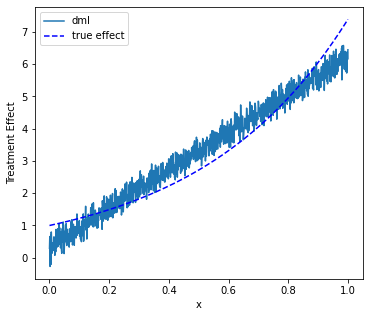

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.plot(X_test1[:, 0], predicted, label='dml')
# plt.fill_between(X_test[:, 0], lb, ub, alpha=.4)
plt.plot(X_test1[:, 0], true_te, 'b--', label='true effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

## Multiple continuous treatment.
Valid estimation models include
- DoubleML
- DeepIV

### The dataset is generated by the following process
Below we use the einstein notation to alleviate the headaches of specifiying dimensions of tensors.
\begin{align*}
    x & = \beta_i w^i + \eta, \quad \eta\sim \text{Uniform}(-1, 1) \\
    y & = x \theta(v) + (x^2) \phi^j(v) + \gamma_k w^k + \epsilon, \quad \epsilon \sim \text{Uniform}(-1, 1)\\
    w & \sim \text{Normal}(0, I_{n_w})\\
    v & \sim \text{Uniform}(0, 1)^{n_v}
\end{align*}

We let 
\begin{equation}
    \theta(v) = e^{2v}, \quad \phi(v) = \ln (3v)
\end{equation}

In [15]:
train2, val2, test = multi_continuous_treatment()
data_test2 = test[0]
true_te1 = test[1]
true_te2 = test[2]

In [16]:
adjustment2 = train2.columns[:-10]
covariate2 = train2.columns[-10:-5]
treatment2 = train2.columns[-5: -3]
outcome2 = 'outcome'

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

dml2 = DML4CATE(
    x_model=MultiOutputRegressor(GradientBoostingRegressor()),
    y_model=GradientBoostingRegressor(),
    cf_fold=1,
    is_discrete_treatment=False,
)
dml2.fit(
    data=train2,
    outcome=outcome2,
    treatment=treatment2,
    adjustment=adjustment2,
    covariate=covariate2,
)

DML4CATE(x_model=MultiOutputRegressor(estimator=GradientBoostingRegressor()), y_model=GradientBoostingRegressor(), yx_model=LinearRegression())

In [18]:
effect2 = dml2.estimate(data=data_test2)

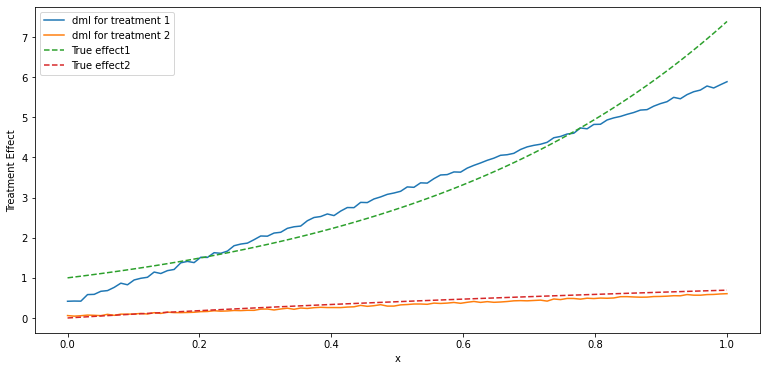

In [19]:
X_test = np.random.uniform(0, 1, size=(100, 5))
X_test[:, 0] = np.linspace(0, 1, 100)

plt.figure(figsize=(13, 6))
plt.plot(X_test[:, 0], effect2[:, :, 0], label='dml for treatment 1')
plt.plot(X_test[:, 0], effect2[:, :, 1], label='dml for treatment 2')
plt.plot(X_test[:, 0], true_te1, '--', label='True effect1')
plt.plot(X_test[:, 0], true_te2, '--', label='True effect2')
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()


## Single continuous treatment observational data

valid estimation models include
- DeepIV
- DoubleML
- CausalTree

We perform our test on Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. \textbf{We will reveal that lower income consumers are more price-sensive.}[1]

[1] https://github.com/microsoft/EconML/blob/main/notebooks/Double%20Machine%20Learning%20Examples.ipynb

In [20]:
import os
import urllib.request

from sklearn.preprocessing import StandardScaler

Data preprocessing

In [21]:
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)

oj_data = pd.read_csv(file_name)
oj_data['price'] = np.log(oj_data['price'])

In [22]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,1.353255,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,1.353255,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,1.353255,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,1.353255,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,1.353255,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [23]:
oj_data.columns

Index(['store', 'brand', 'week', 'logmove', 'feat', 'price', 'AGE60', 'EDUC',
       'ETHNIC', 'INCOME', 'HHLARGE', 'WORKWOM', 'HVAL150', 'SSTRDIST',
       'SSTRVOL', 'CPDIST5', 'CPWVOL5'],
      dtype='object')

In [24]:
outcome3 = 'logmove'
treatment3 = 'price'
adjustment3 = [c for c in oj_data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]
covariate3 = 'INCOME'

In [25]:
x_ = oj_data[treatment3].values
y_ = oj_data[outcome3].values
scaler = StandardScaler()
w_ = scaler.fit_transform(oj_data[adjustment3].values)
w_prime = pd.get_dummies(oj_data[['brand']]).values
w = np.concatenate((w_, w_prime), axis=1)
v = scaler.fit_transform(oj_data[[covariate3]].values).ravel()

In [26]:
adjustment3.append('brand')
transfomred_data_dict = {treatment3: x_,
                         outcome3: y_,
                         covariate3: v,}
for i, wwww in enumerate(adjustment3):
    transfomred_data_dict[wwww] = w[:, i].ravel()

In [27]:
transfomred_data = pd.DataFrame(transfomred_data_dict)

In [28]:
transfomred_data.head()

,price,logmove,INCOME,feat,AGE60,EDUC,ETHNIC,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,brand
0,1.353255,9.018695,-0.225035,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
1,1.353255,8.723231,-0.225035,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
2,1.353255,8.253228,-0.225035,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
3,1.353255,8.987197,-0.225035,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
4,1.353255,9.093357,-0.225035,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0


In [29]:
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1,1)

In [30]:
dml3 = DML4CATE(
    x_model=RandomForestRegressor(),
    y_model=RandomForestRegressor(),
    cf_fold=4,
)
dml3.fit(
    data=transfomred_data,
    outcome=outcome3,
    treatment=treatment3,
    adjustment=adjustment3,
    covariate=covariate3,
)

DML4CATE(x_model=RandomForestRegressor(), y_model=RandomForestRegressor(), yx_model=LinearRegression(), cf_fold=4)

In [31]:
mx = RandomForestRegressor()
my = RandomForestRegressor()
wv = np.concatenate((w, v.reshape(-1, 1)), axis=1)
mx.fit(wv, x_)
my.fit(wv, y_)
yprime = y_ - my.predict(wv).reshape(y_.shape)
xhat = x_ - mx.predict(wv).reshape(x_.shape)
xprime = (xhat * v).reshape(-1, 1)
l = LinearRegression()
l.fit(xprime, yprime.reshape(-1, 1))
(l.coef_ - dml3.yx_model.coef_) / dml3.yx_model.coef_

array([[-1.14037113,  1.21216305]])

In [32]:
test_data = transfomred_data.copy(deep=True)[:X_test.shape[0]]
test_data[covariate3] = X_test.ravel()
effect3 = dml3.estimate(data=test_data)

In [33]:
test_data.head()

,price,logmove,INCOME,feat,AGE60,EDUC,ETHNIC,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,brand
0,1.353255,9.018695,-1.00,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
1,1.353255,8.723231,-0.98,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
2,1.353255,8.253228,-0.96,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
3,1.353255,8.987197,-0.94,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0
4,1.353255,9.093357,-0.92,-0.557732,0.965476,0.215706,-0.220052,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,0.0


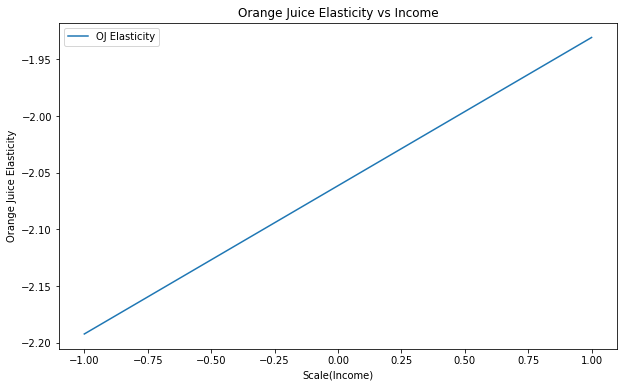

In [34]:
plt.figure(figsize=(10,6))
plt.plot(X_test, effect3.squeeze(), label="OJ Elasticity")
plt.xlabel(r'Scale(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

## Multiple continuous treatment, multiple outcome observational data.

In [35]:
oj_data = pd.read_csv(file_name)
oj_data['price'] = np.log(oj_data["price"])
groupbylist = ["store", "week", "AGE60", "EDUC", "ETHNIC", "INCOME",
               "HHLARGE", "WORKWOM", "HVAL150",
               "SSTRDIST", "SSTRVOL", "CPDIST5", "CPWVOL5"]
oj_data1 = pd.pivot_table(oj_data,index=groupbylist,
                          columns=oj_data.groupby(groupbylist).cumcount(),
                          values=['logmove', 'price'],
                          aggfunc='sum').reset_index()
oj_data1.columns = oj_data1.columns.map('{0[0]}{0[1]}'.format) 
oj_data1 = oj_data1.rename(index=str,
                           columns={"logmove0": "logmove_T",
                                    "logmove1": "logmove_M",
                                    "logmove2":"logmove_D",
                                    "price0":"price_T",
                                    "price1":"price_M",
                                    "price2":"price_D"})



In [36]:
oj_data1.head()

,store,week,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,logmove_T,logmove_M,logmove_D,price_T,price_M,price_D
0,2,40,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927,9.018695,8.407378,9.264829,1.353255,1.153732,0.463734
1,2,46,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927,8.723231,8.449343,8.987197,1.353255,1.153732,0.989541
2,2,47,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927,8.253228,9.911456,8.831712,1.353255,0.871293,0.737164
3,2,48,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927,8.987197,7.896553,7.965546,1.353255,1.153732,0.737164
4,2,50,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927,9.093357,8.009031,7.377759,1.353255,1.153732,0.737164


In [37]:
outcome4 = ['logmove_T', 'logmove_M', 'logmove_D']
treatment4 = ['price_T', 'price_M', 'price_D']
adjustment4 = [c for c in groupbylist if c not in ['week', 'store', 'INCOME']]
covariate4 = ['INCOME']

In [38]:
scaler = StandardScaler()
w4 = scaler.fit_transform(oj_data1[adjustment4].values)
x4 = scaler.fit_transform(oj_data1[covariate4].values)

In [39]:
for i, name in enumerate(adjustment4):
    oj_data1[name] = w4[:, i]
oj_data1[covariate4] = x4
oj_data1.head()

,store,week,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,logmove_T,logmove_M,logmove_D,price_T,price_M,price_D
0,2,40,0.965476,0.215706,-0.220052,-0.225035,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,9.018695,8.407378,9.264829,1.353255,1.153732,0.463734
1,2,46,0.965476,0.215706,-0.220052,-0.225035,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,8.723231,8.449343,8.987197,1.353255,1.153732,0.989541
2,2,47,0.965476,0.215706,-0.220052,-0.225035,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,8.253228,9.911456,8.831712,1.353255,0.871293,0.737164
3,2,48,0.965476,0.215706,-0.220052,-0.225035,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,8.987197,7.896553,7.965546,1.353255,1.153732,0.737164
4,2,50,0.965476,0.215706,-0.220052,-0.225035,-0.386145,-1.055453,0.502548,-0.860274,-0.122426,-0.26456,-0.282733,9.093357,8.009031,7.377759,1.353255,1.153732,0.737164


In [40]:
oj_data1.columns

Index(['store', 'week', 'AGE60', 'EDUC', 'ETHNIC', 'INCOME', 'HHLARGE',
       'WORKWOM', 'HVAL150', 'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5',
       'logmove_T', 'logmove_M', 'logmove_D', 'price_T', 'price_M', 'price_D'],
      dtype='object')

In [41]:
from sklearn import linear_model
dml4 = DML4CATE(
    x_model=MultiTaskElasticNetCV(),
    y_model=MultiTaskElasticNetCV(),
    yx_model=None,
    cf_fold=6,
)
dml4.fit(
    data=oj_data1,
    outcome=outcome4,
    treatment=treatment4,
    adjustment=adjustment4,
    covariate=covariate4,
)

DML4CATE(x_model=MultiTaskElasticNetCV(), y_model=MultiTaskElasticNetCV(), yx_model=LinearRegression(), cf_fold=6)

In [42]:
min_income = -1
max_income = 1
delta = (1 - (-1)) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)
test_data4 = oj_data1.copy(deep=True)[:X_test.shape[0]]
test_data4[covariate4] = X_test

effect4 = dml4.estimate(test_data4)

In [43]:
oj_data1.columns

Index(['store', 'week', 'AGE60', 'EDUC', 'ETHNIC', 'INCOME', 'HHLARGE',
       'WORKWOM', 'HVAL150', 'SSTRDIST', 'SSTRVOL', 'CPDIST5', 'CPWVOL5',
       'logmove_T', 'logmove_M', 'logmove_D', 'price_T', 'price_M', 'price_D'],
      dtype='object')

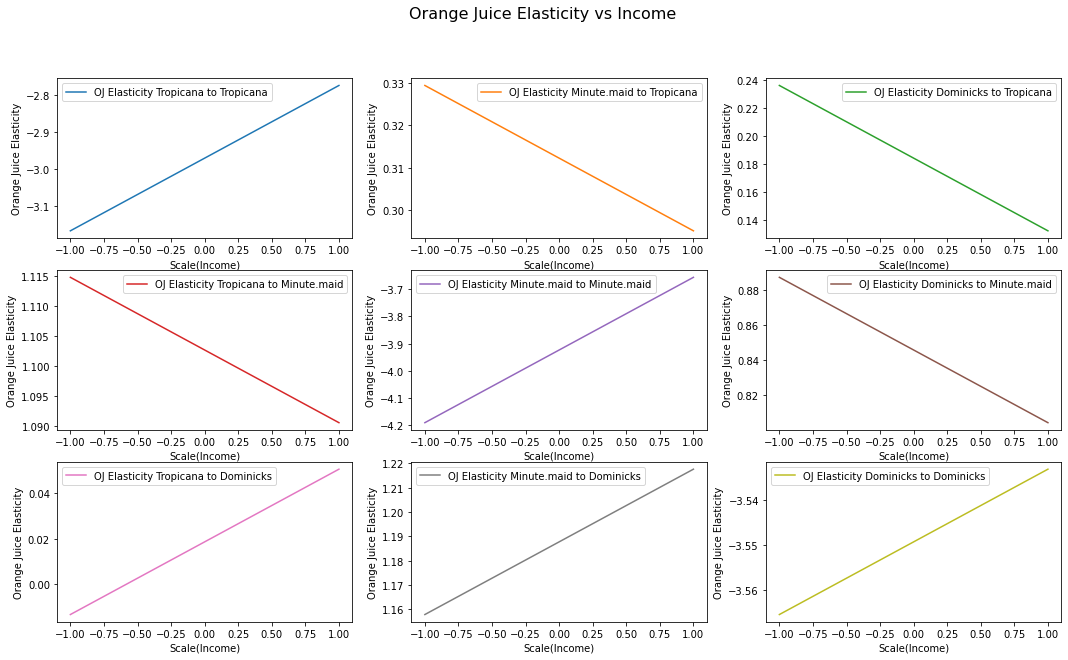

In [44]:
plt.figure(figsize=(18, 10))
dic={0:"Tropicana", 1:"Minute.maid", 2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, 3 * i + j + 1)
        plt.plot(X_test, effect4[:, i, j],
                 color="C{}".format(str(3 * i + j)),
                 label="OJ Elasticity {} to {}".format(dic[j], dic[i]))
        plt.xlabel(r'Scale(Income)')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income", fontsize=16)
plt.show()


In [45]:
xmodel = MultiTaskElasticNetCV()
xmodel.fit(oj_data1[['INCOME'] + adjustment4].values, oj_data1[treatment4])
x_hat = xmodel.predict(oj_data1[['INCOME']+adjustment4].values)
ymodel = MultiTaskElasticNetCV()
ymodel.fit(oj_data1[['INCOME']+adjustment4].values, oj_data1[outcome4])
yhat = ymodel.predict(oj_data1[['INCOME']+adjustment4].values)
# x_hat = dml4.x_hat_dict['paras'][0]
# y_hat = dml4.y_hat_dict['paras'][0]
xprime = nd_kron(oj_data1[treatment4].values - x_hat, oj_data1[['INCOME']].values)
yprime = oj_data1[outcome4].values - yhat
lr = linear_model.LinearRegression()
lr.fit(xprime, yprime)
c = lr.coef_
c

array([[ 0.33285236, -0.05867611, -0.06675376],
       [-0.09049298,  0.51610244, -0.1371895 ],
       [ 0.03084033, -0.11316553,  0.26850266]])